<header style="text-align: center; padding: 20px;">
  <h1 style="font-size: 2.5em; margin-bottom: 0.2em;">📊 Financial Time Series Analysis</h1>
  <h2 style="font-weight: normal; font-size: 1.5em; color: #555;">Multivariate GARCH and Var Analysis</h2>
  <p style="font-size: 1.1em; color: #888;">Project | Time Series Analysis | Spring 2025</p>
  <hr style="margin-top: 20px; border: none; border-top: 1px solid #ccc;">
</header>


- Stock: Boeing Group (NYSE)
- Index: SP500
- Crypto: ETH
- Change: USD/PLN
- Commoditiy: gold

In [43]:
#! pip install investpy
#! pip install requests-cache
#! pip install yfinance

In [12]:
# Import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf  # equivalent to quantmod
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch import arch_model  # equivalent to fGarch
from scipy import stats
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt

from curl_cffi import requests

import requests_cache
import investpy
import pickle
import os

# Display settings
# plt.style.use('seaborn')
pd.set_option('display.float_format', lambda x: '%.5f' % x)

from data_engineering import DataDownloader 
downloader = DataDownloader() #create isance of the class in our main method

import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.dates as mdates

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



## Importing the data:

In [2]:
tickers = ['^GSPC', 'BA', 'ETH-USD', 'PLN=X', 'GC=F']
data_dict = downloader.load_or_download_data(tickers, start='2020-05-01', end='2024-05-01') #call external class to download
gspc = data_dict.get('gspc')
ba = data_dict.get('ba')
eth = data_dict.get('ethusd')
usdpln = data_dict.get('plnx')
gold = data_dict.get('gcf')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


✅ Data downloaded and saved successfully.


### Refine, set working week and check NaN

In [3]:
# Resample to business days (5-day week), forward fill missing prices
for name, df in data_dict.items():
    # Ensure index is datetime
    df.index = pd.to_datetime(df.index)

    # Reindex to business days (5-day weeks)
    business_days = pd.date_range(start=df.index.min(), end=df.index.max(), freq='B')
    df_reindexed = df.reindex(business_days)

    # Store back the cleaned data
    data_dict[name] = df_reindexed

    # Check for missing values
    missing = df_reindexed.isna().sum()
    if missing.sum() > 0:
        print(f"\n❗ Missing values in {name.upper()}:")
        print(missing[missing > 0])
    else:
        print(f"\n✅ No missing values in {name.upper()}")



❗ Missing values in GSPC:
Price
Open      37
High      37
Low       37
Close     37
Volume    37
dtype: int64

❗ Missing values in BA:
Price
Open      37
High      37
Low       37
Close     37
Volume    37
dtype: int64

✅ No missing values in ETHUSD

✅ No missing values in PLNX

❗ Missing values in GCF:
Price
Open      37
High      37
Low       37
Close     37
Volume    37
dtype: int64


### Technical Considerations – Data Alignment

One of the main issues in working with financial time series is the **difference in trading calendars** between asset classes:

- **FX, cryptocurrencies, and commodities** are traded **continuously**, including weekends and many public holidays.
- **Stocks and ETFs**, however, follow the **U.S. NYSE trading calendar**, which consists of:
  - **5 trading days per week** (Monday to Friday)
  - **Exclusion of U.S. market holidays**

---

### Alignment Strategy

To ensure consistency across all datasets, we adopt the **Stock Exchange calendar (NYSE)** as our reference. This means:

- We reindex all continuous trading instruments (such as FX or crypto) to match the **stock market trading days**.
- Trading data available on weekends or holidays for these continuous assets is treated as **after-hours activity** and is **excluded** from our analysis.

This approach ensures all datasets share a **common and aligned time index**, making them suitable for comparison, modeling, and joint analysis.


In [47]:
def clean_align(data_dict, reference_df, output_dir='../data/aligned_clean'):
    
    """
    Aligns all datasets in `data_dict` to the trading calendar of `reference_df` (e.g., GSPC),
    removes rows with all NaNs, and saves the cleaned datasets to pickle files.

    Parameters:
        data_dict (dict): Dictionary of {name: DataFrame} to be aligned and cleaned.
        reference_df (pd.DataFrame): Reference DataFrame whose index defines the stock calendar.
        output_dir (str): Directory where cleaned pickle files will be saved.
    """

    # 1. Use reference index (trading days) from GSPC
    trading_days = reference_df.index

    # 2. Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # 3. Align and clean each DataFrame
    for name, df in data_dict.items():
        print(f"📦 Pulizia in corso: {name.upper()}")

        # Reindex to stock trading calendar
        df_clean = df.reindex(trading_days)

        # Drop rows with all NaNs
        df_clean.dropna(how='all', inplace=True)

        # Save as pickle
        with open(os.path.join(output_dir, f"{name}.pkl"), 'wb') as f:
            pickle.dump(df_clean, f)

        # Update the dictionary in place
        data_dict[name] = df_clean

    print("\n✅ Tutti i dataset sono stati riallineati, ripuliti e salvati in:", output_dir)


In [48]:
clean_align(data_dict, gspc)

📦 Pulizia in corso: GSPC
📦 Pulizia in corso: BA
📦 Pulizia in corso: ETHUSD
📦 Pulizia in corso: PLNX
📦 Pulizia in corso: GCF

✅ Tutti i dataset sono stati riallineati, ripuliti e salvati in: ../data/aligned_clean


# Closing Prices

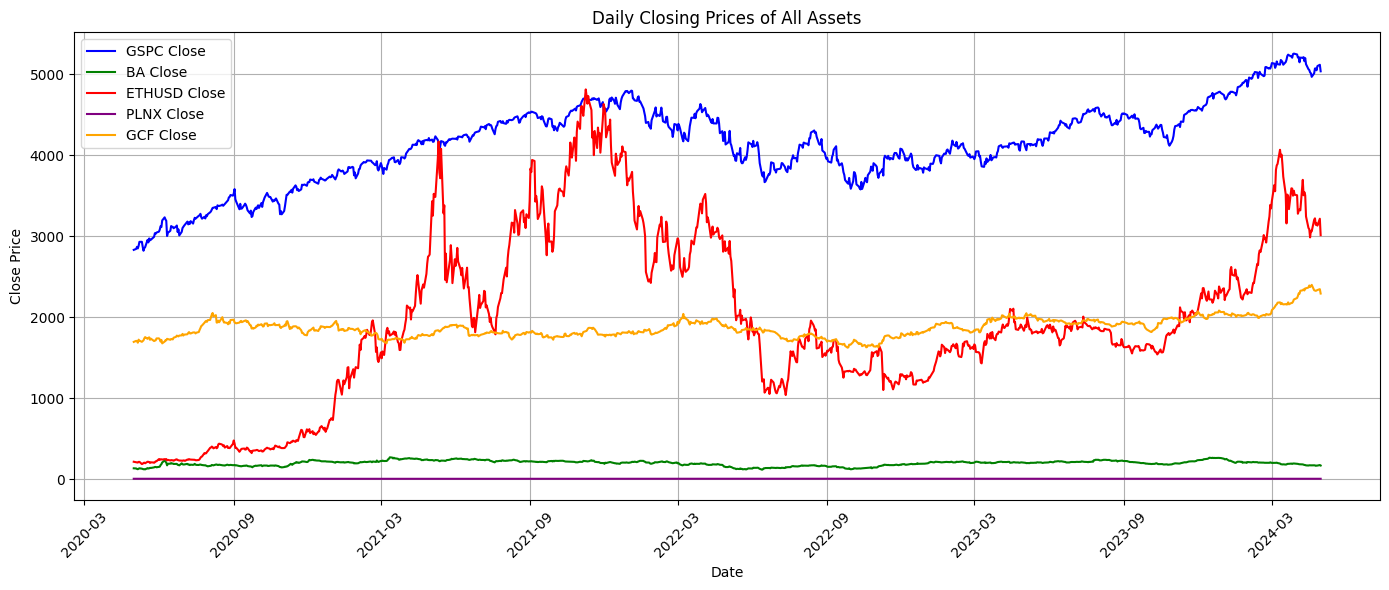

In [49]:
import matplotlib.dates as mdates

# Define color palette
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'cyan']

# Start the plot
plt.figure(figsize=(14, 6))

# Plot each asset's closing price
for i, (name, df) in enumerate(data_dict.items()):
    if 'Close' in df.columns:
        plt.plot(df.index, df['Close'], label=f'{name.upper()} Close', color=colors[i % len(colors)])

# Format axes
plt.title('Daily Closing Prices of All Assets')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In order to appreciate the changing on PLN/USD asset we need to plot it alone instahed of rescale

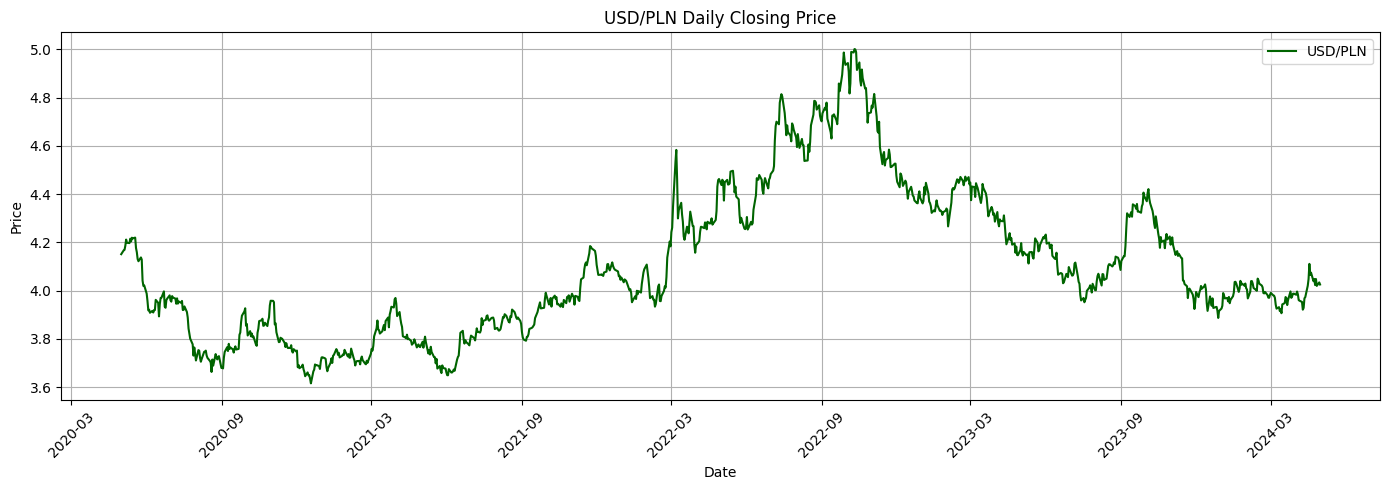

In [50]:
# Get USD/PLN data (key should be 'plnx' after conversion)
usdpln = data_dict.get('plnx')

if usdpln is not None and 'Close' in usdpln.columns:
    plt.figure(figsize=(14, 5))
    plt.plot(usdpln.index, usdpln['Close'], color='darkgreen', label='USD/PLN')

    plt.title('USD/PLN Daily Closing Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.legend()

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()
else:
    print("USD/PLN data not found or missing 'Close' column.")


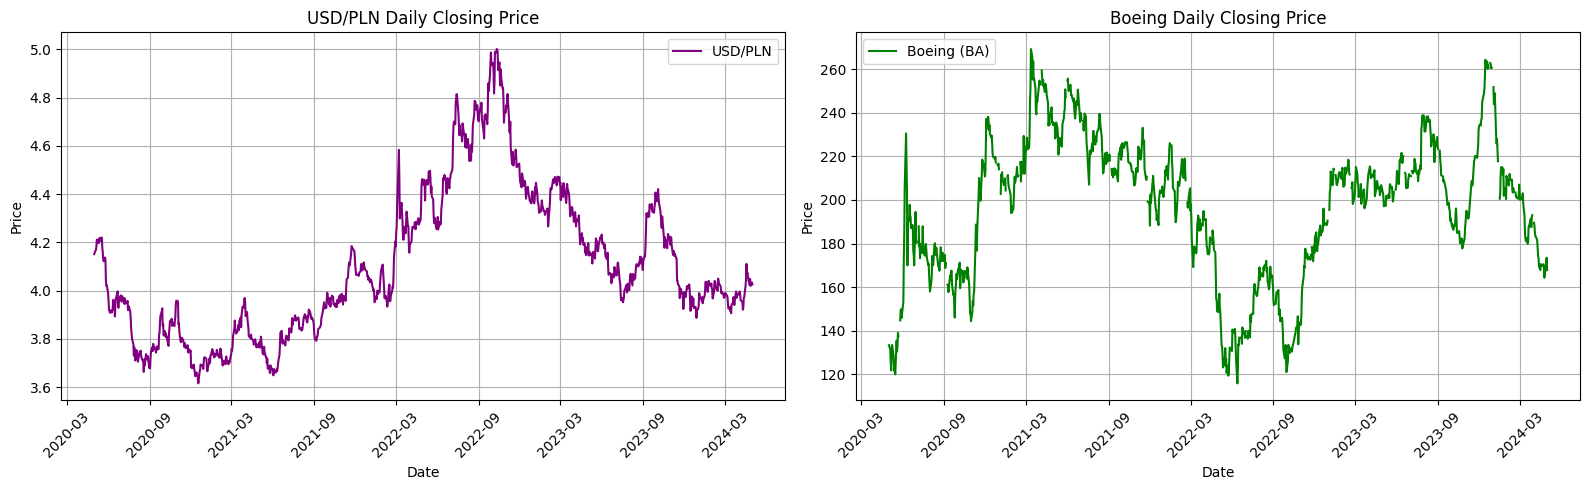

In [7]:
# Get USD/PLN and Boeing data
usdpln = data_dict.get('plnx')
boeing = data_dict.get('ba')

if usdpln is not None and boeing is not None and 'Close' in usdpln.columns and 'Close' in boeing.columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharex=True)

    # Plot USD/PLN
    axes[0].plot(usdpln.index, usdpln['Close'], color='purple', label='USD/PLN')
    axes[0].set_title("USD/PLN Daily Closing Price")
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("Price")
    axes[0].grid(True)
    axes[0].legend()
    axes[0].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    axes[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    axes[0].tick_params(axis='x', rotation=45)

    # Plot Boeing (BA)
    axes[1].plot(boeing.index, boeing['Close'], color='green', label='Boeing (BA)')
    axes[1].set_title("Boeing Daily Closing Price")
    axes[1].set_xlabel("Date")
    axes[1].set_ylabel("Price")
    axes[1].grid(True)
    axes[1].legend()
    axes[1].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    axes[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

else:
    print("USD/PLN or Boeing data not found or missing 'Close' column.")


## LOG RETURNS

From this point onward, we will use log-returns (i.e., the natural logarithm of price relatives) as our primary measure of asset returns throughout the analysis.
Log-returns are widely preferred in finance and econometrics for several reasons — to name just a few:

1. Time Additivity: Log-returns can be summed over time intervals, making them suitable for cumulative return calculations and for time series modeling.

2. Suitability for Volatility Modelling: GARCH-type models and other conditional volatility frameworks are typically applied to log-returns, as they often exhibit clearer volatility clustering and more regular statistical properties (as will become evident later in the analysis).

As a note, we calculate the log-returns using the closing price for the days t and t-1, so that we get the so said log-return 'close to close'. The choice of close-to-close log returns is not arbitrary but is motivated by their ability to incorporate both intra-day and overnight price dynamics.
Unlike returns computed over specific intraday intervals, close-to-close returns capture the full effect of market activity, including periods when the market is officially closed but price-relevant information is still being absorbed — such as after-hours news, earnings releases, or macroeconomic announcements.

This means that close-to-close returns embed a component of overnight volatility, which is particularly relevant for modeling total risk and for estimating volatility using GARCH-type models. Ignoring this component would lead to an underestimation of true return variability, especially in assets or markets that are sensitive to after-hours information flows.

We begin by plotting the daily log-returns for each of the five components: a stock (Boeing), a stock index (S&P 500), a cryptocurrency (Ethereum), a commodity (Gold), and a foreign exchange rate (USD/PLN).
These plots provide a preliminary visual inspection of the return behavior of each asset, highlighting possible volatility patterns, jumps, or outliers. In particular, we aim to identify early signs of heteroscedasticity and volatility clustering, which are key motivations for the use of GARCH-type models later in the analysis.

$$
r_{t}=\ln({\frac{P_t}{P_{t-1}}})
$$


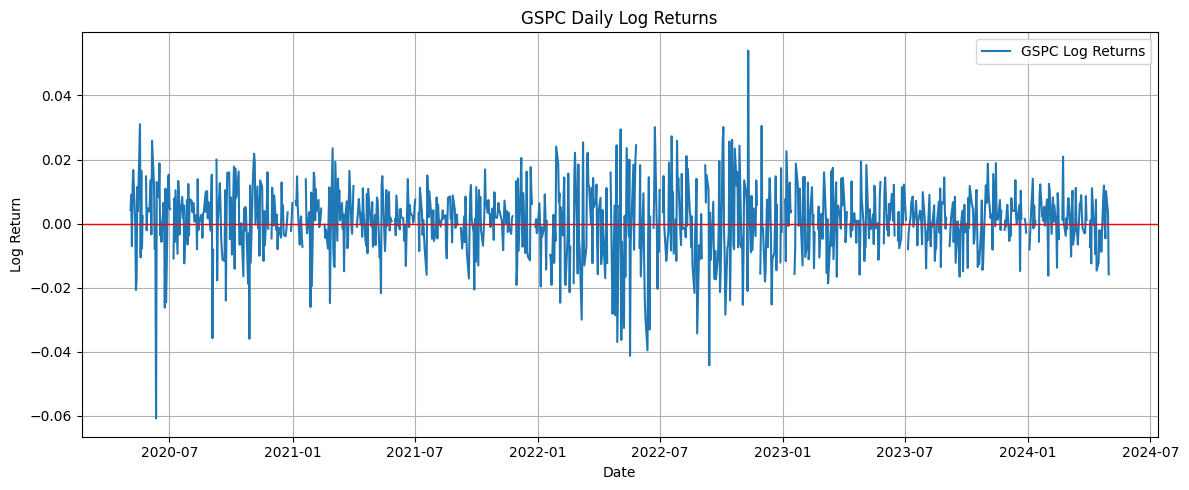

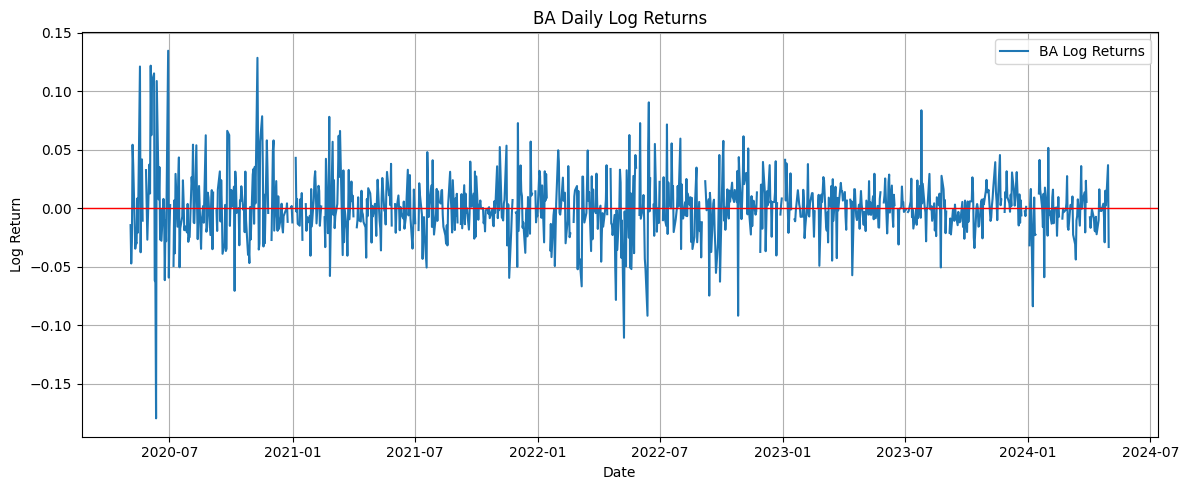

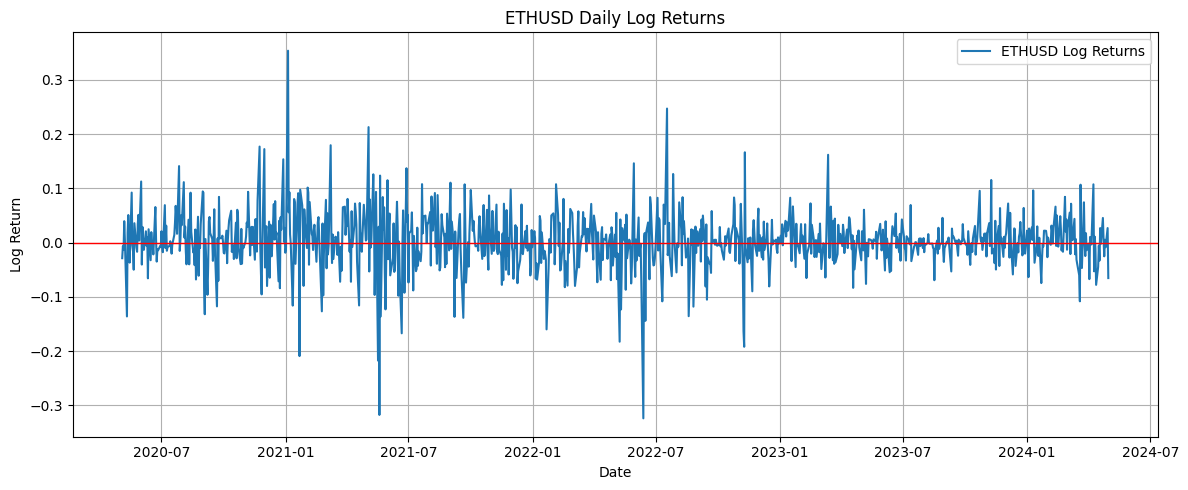

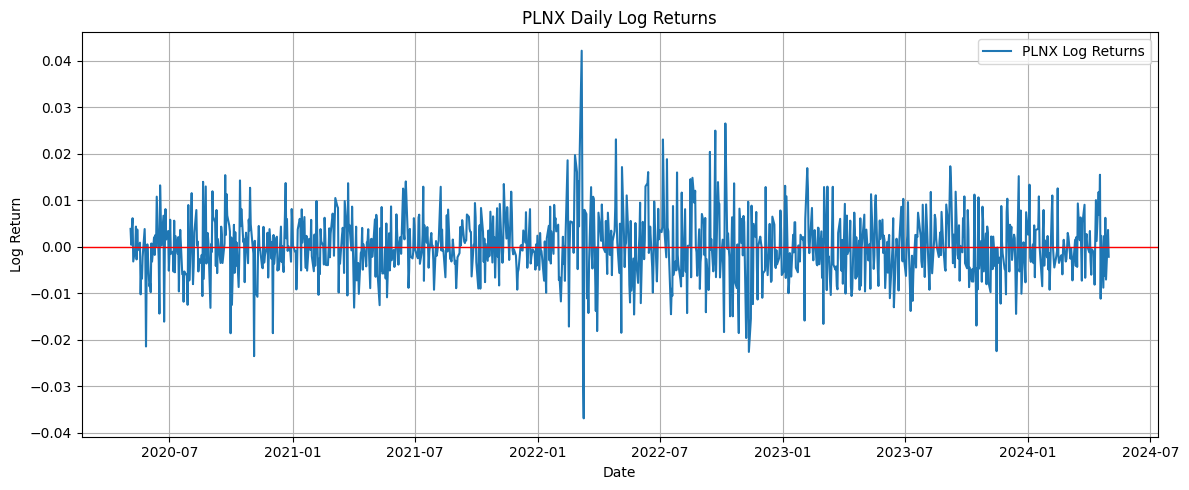

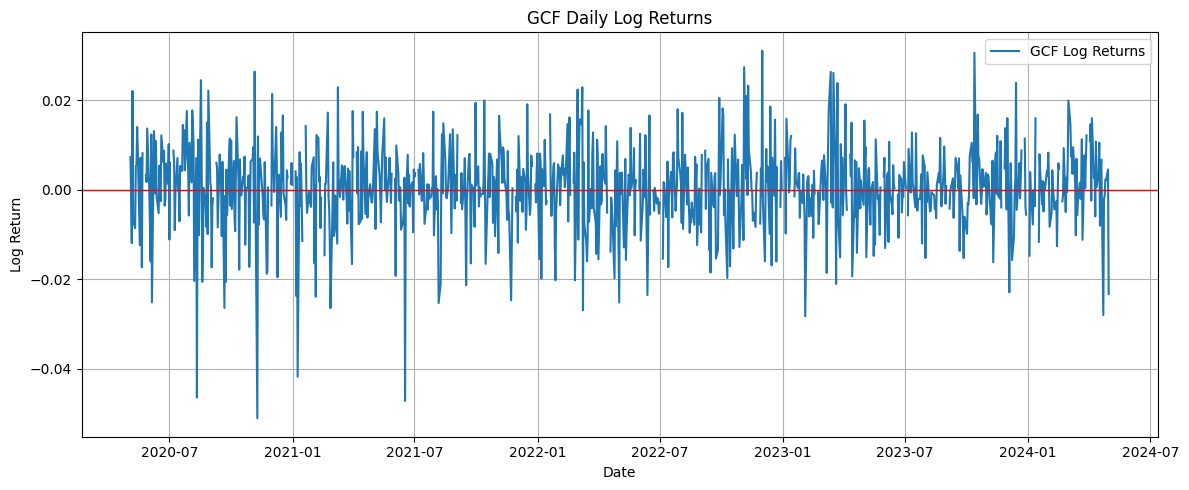

In [11]:
for name, df in data_dict.items():
    if 'Close' in df.columns:
        df = df.copy()
        df['log_return'] = np.log(df['Close']).diff()
        plt.figure(figsize=(12, 5))
        plt.plot(df.index, df['log_return'], label=f'{name.upper()} Log Returns')
        plt.axhline(y=0, color='red', linestyle='-', linewidth=1)  # Add red horizontal line at y = 0
        plt.title(f'{name.upper()} Daily Log Returns')
        plt.xlabel('Date')
        plt.ylabel('Log Return')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()


## **Equally Weighted Portfolio** Daily Log Returns 

The time series plots of daily log returns for all five assetes reveal a common and important empirical feature: heteroskedasticity, that is, the variance of returns varies over time. This is visually apparent through alternating periods of high volatility (large swings in returns) and low volatility (smaller, more stable fluctuations). Visual inspection provides valuable intuition, but it must be complemented with rigorous statistical tests to confirm the existence of ARCH effects (Autoregressive Conditional Heteroskedasticity), which are the foundation for GARCH-type models.

The next step involves computing the log return of the portfolio, defined as an equally weighted average of the five individual asset returns analyzed above. A fixed weight of 20% is assigned to each asset, representing a balanced allocation that gives equal importance to all components in the portfolio. As a consequence, we assume the portfolio is daily rebalanced to preserve these fixed weights over time. Under this assumption, the log-return of the portfolio can be computed as the weighted sum of the individual asset log-returns:
$$
r_{p,t} = \sum_{i=1}^{5} w_i \cdot r_{i,t}
$$

In [17]:
# Step 1: Create a list of DataFrames containing each asset's log return
log_returns = []

for name, df in data_dict.items():
    if 'Close' in df.columns:
        df = df.copy()
        df['log_return'] = np.log(df['Close']).diff()
        log_return_series = df[['log_return']].rename(columns={'log_return': name})
        log_returns.append(log_return_series)

# Step 2: Concatenate all log returns into a single DataFrame aligned by date
log_return_df = pd.concat(log_returns, axis=1)

# Step 3: Drop rows with missing values to ensure alignment
log_return_df.dropna(inplace=True)

# Step 4: Calculate equally weighted portfolio log return
n_assets = log_return_df.shape[1]
log_return_df['portfolio'] = log_return_df.dot(np.repeat(1/n_assets, n_assets))


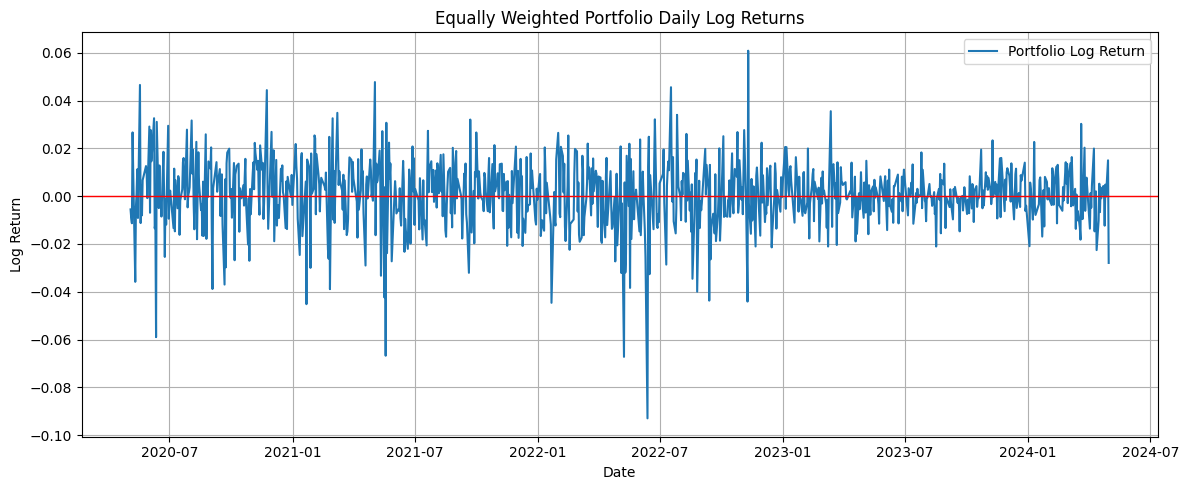

In [30]:
plt.figure(figsize=(12, 5))
plt.plot(log_return_df.index, log_return_df['portfolio'], label='Portfolio Log Return', color='#1f77b4')
plt.axhline(y=0, color='red', linestyle='-', linewidth=1)  # Add red horizontal line at y = 0
plt.title('Equally Weighted Portfolio Daily Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Although diversification should reduce the magnitude of extreme movements compared to individual assets, noticeable fluctuations and persistent periods of high and low volatility still emerge. This justifies further investigation into the portfolio’s volatility dynamics using conditional heteroskedasticity models.

# Investigating volatility stylized facts


In this section, we explore the stylized facts of financial volatility, which are essential for understanding the empirical behavior of asset returns and for motivating the use of certain conditional volatility models.

In order to do so, a brief explanaton of the volatility is required:
Volatility is closely related to the likelihood of observing extreme values in asset returns — whether very high or very low. However, from a statistical perspective, volatility must be clearly distinguished from the unconditional variance of returns.
In fact, volatility is a forward-looking measure of risk: given a planned holding period [t,t+k] volatility is defined as the conditional variance of returns over that horizon, based on the information available at time 
𝑡. Formally:

$$
v_{t+k,k}=Var(r_{t+k,k}|\mathcal{I_t})=E[r^2_{t+k,k}|\mathcal{I_t}]-(E[r_{t+k,k}|\mathcal{I_t}])^2
$$

By conditioning on the information set $\mathcal{I_t}$, volatility becomes state-dependent, adapting to current market conditions. This is in stark contrast to the unconditional variance, which assumes constant risk over time and across all scenarios.
As a result, volatility is considered a latent variable — it cannot be observed directly, but must be inferred through appropriate models.
To study volatility empirically, we rely on observable proxies. In this analysis, we adopt the squared log-returns as our primary proxy. This choice is both practical and theoretically sound, as squared returns reflect the magnitude of return fluctuations regardless of direction and align naturally with the structure of ARCH and GARCH models; indeed, if we assume (and, in general, this hypothesis is true) that the returns are zero mean, the squared log-return is an unbiased estimator for the volatility:
$$
E[v_t]=E[r^2_t]
$$

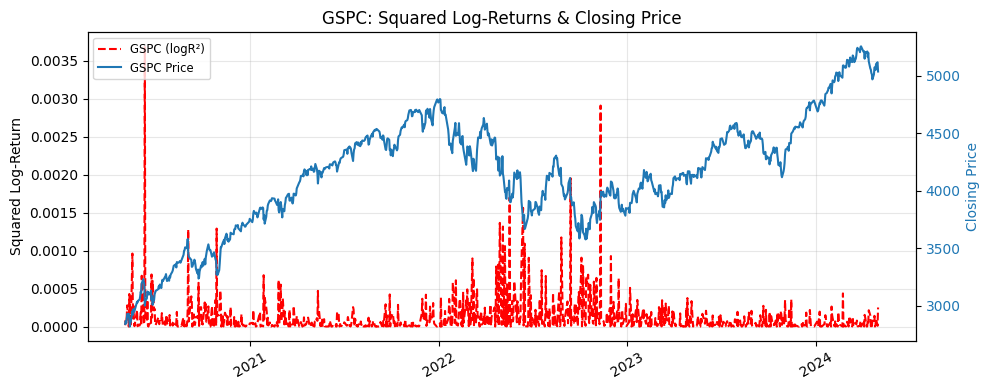

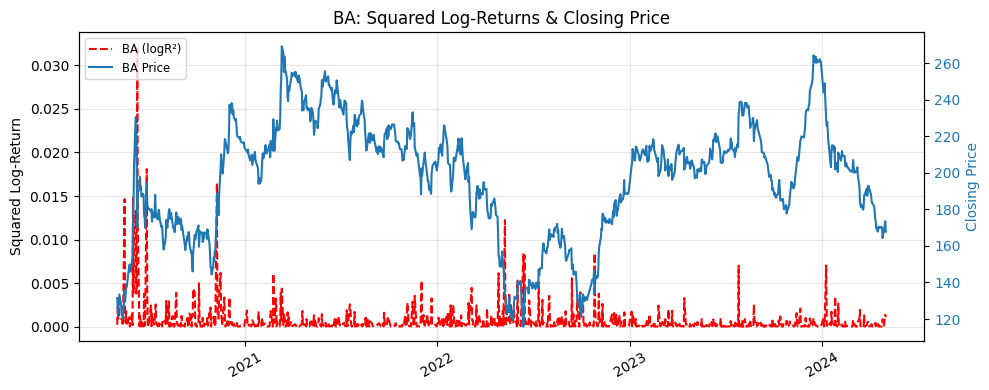

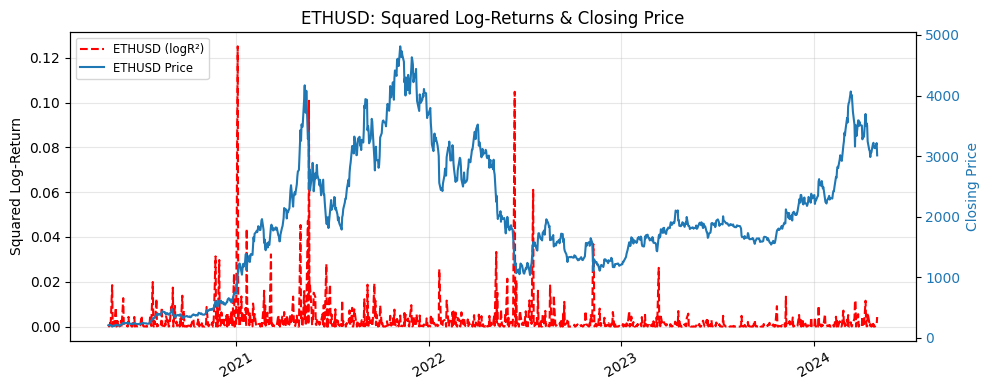

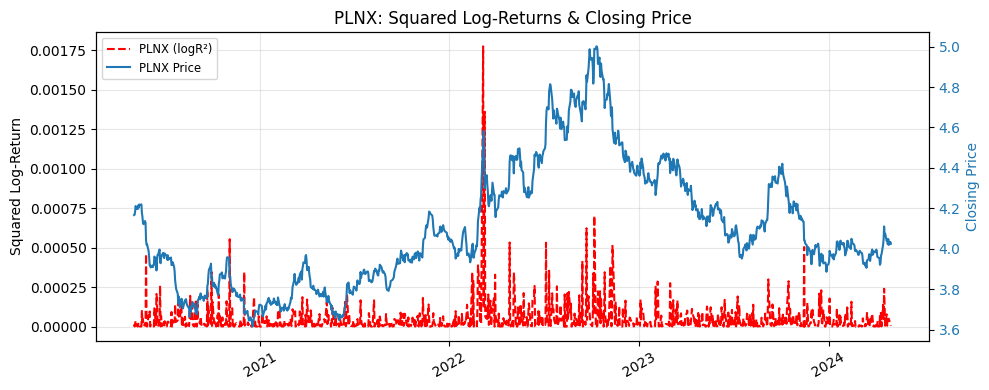

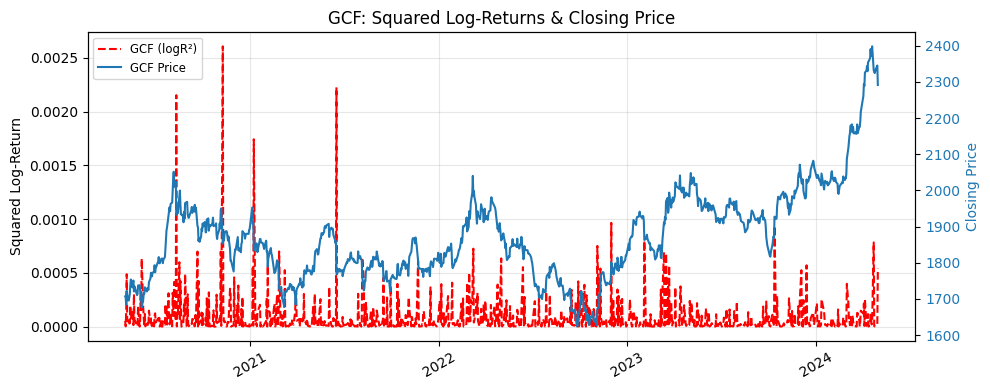

In [23]:
for name, df in data_dict.items():
    if 'Close' not in df.columns:
        continue

    # Prepare DataFrame
    df = df.copy()
    if 'log_return' not in df.columns:
        df['log_return'] = np.log(df['Close']).diff()
    df = df.dropna(subset=['log_return'])

    # Create figure and primary axis
    fig, ax = plt.subplots(figsize=(10, 4))

    # 1) Plot squared log‐returns (red dashed)
    ax.plot(
        df.index,
        df['log_return']**2,
        linestyle='--',
        color='red',
        label=f'{name.upper()} (logR²)'
    )
    ax.set_ylabel('Squared Log-Return')
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=30)
    ax.grid(True, alpha=0.3)

    # 2) Plot closing price (default blue #1f77b4) on secondary axis
    ax2 = ax.twinx()
    ax2.plot(
        df.index,
        df['Close'],
        linestyle='-',
        color='#1f77b4',
        label=f'{name.upper()} Price'
    )
    ax2.set_ylabel('Closing Price', color='#1f77b4')
    ax2.tick_params(axis='y', labelcolor='#1f77b4')

    # 3) Combine legends
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(
        h1 + h2,
        l1 + l2,
        loc='upper left',
        fontsize='small'
    )

    # Title and layout
    plt.title(f'{name.upper()}: Squared Log-Returns & Closing Price')
    plt.tight_layout()
    plt.show()


In these dual‐axis charts, the solid blue line represents the daily closing price and the red dashed line shows the squared log‐returns. Squaring returns compresses small fluctuations toward zero while dramatically amplifying larger moves, making high‐volatility spikes immediately apparent. Calm phases appear as an almost flat red band beneath a smooth price curve, whereas turbulent periods—such as during financial shocks or major news events—produce clustered red peaks corresponding to substantial price swings. This clearly separates low‐volatility regimes from turbulent ones and demonstrates squared log‐returns’ effectiveness as a volatility proxy.
Indeed,these bursts of elevated squared returns, followed by stretches of near‐zero activity, are the hallmark of volatility clustering:

1. Clusters of tall red peaks correspond to sustained high‐volatility episodes, not just single shocks.

2. Flat red bands align with quieter market phases, showing volatility remaining persistently low.

Because those spikes tend to appear in runs (and not randomly), they exhibit positive autocorrelation: high volatility begets more high volatility, and low begets low. That very persistence—clearly visible in the way the red spikes bunch together on the time axis—is what ARCH/GARCH models are designed to capture.

This clustering pattern can be formally tested by examining the autocorrelation function (ACF) of the squared log-returns. Under volatility clustering, the ACF of $r_t^2$​ will display significantly positive values at multiple lags, indicating that today’s large squared return predicts tomorrow’s. In statistical terms, volatility clustering is nothing more than a strong positive autocorrelation structure in the latent variance process.

### AutoCorrelation Function - ACF 

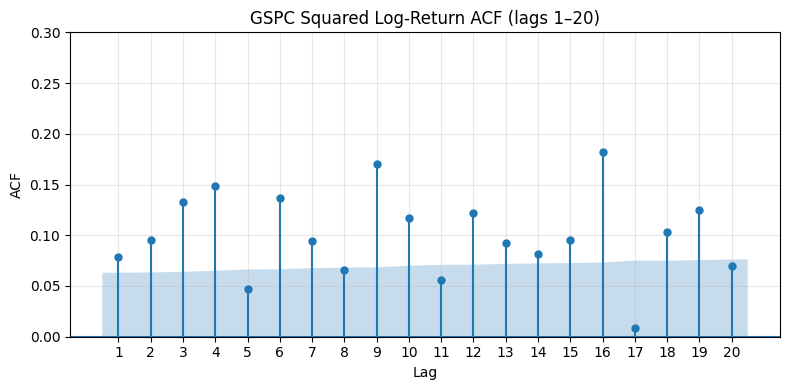

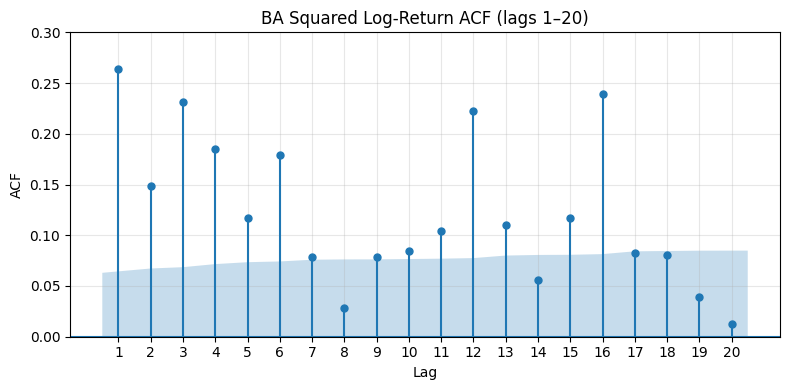

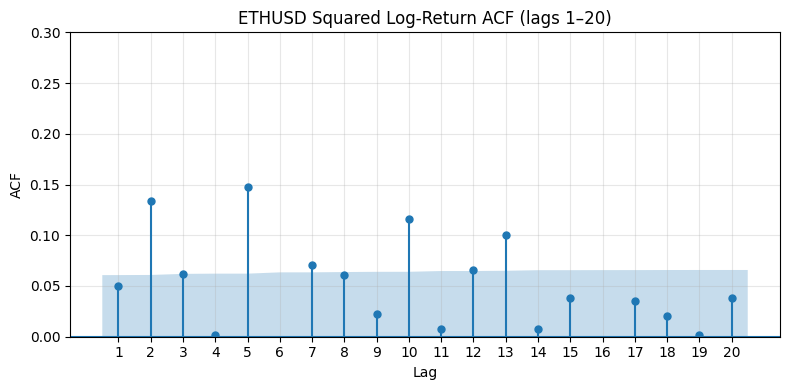

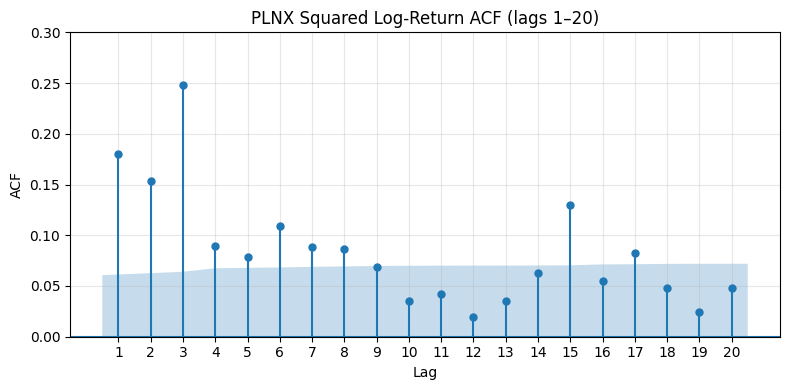

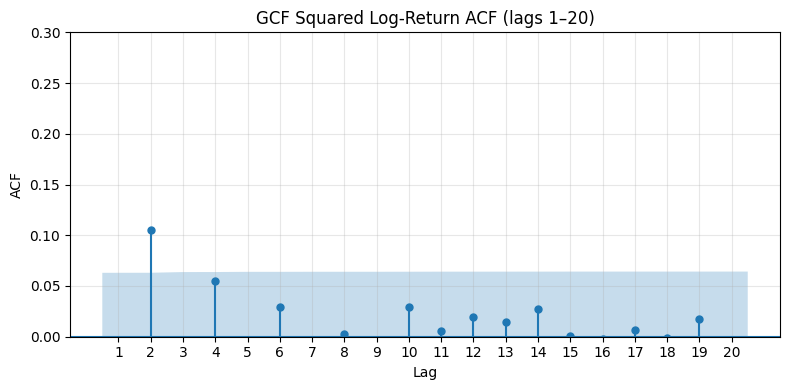

In [27]:
# Number of lags
nlags = 20

# Identify assets
assets = [name for name, df in data_dict.items() if 'Close' in df.columns]

for name in assets:
    df = data_dict[name].copy()
    
    # Compute log‐returns and squared returns
    df['r'] = np.log(df['Close']).diff()
    r2 = df['r'].dropna() ** 2

    # Plot
    fig, ax = plt.subplots(figsize=(8, 4))
    plot_acf(r2, lags=nlags, zero=False, ax=ax)
    
    # Titles and labels
    ax.set_title(f"{name.upper()} Squared Log-Return ACF (lags 1–{nlags})")
    ax.set_xlabel("Lag")
    ax.set_ylabel("ACF")
    
    # Set x‐ticks to integers 1..nlags
    ax.set_xticks(np.arange(1, nlags + 1, 1))
    
    # Constrain y‐axis to [0, 0.4]
    ax.set_ylim(0, 0.30)
    
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

### ACF of entire balanced portfolio

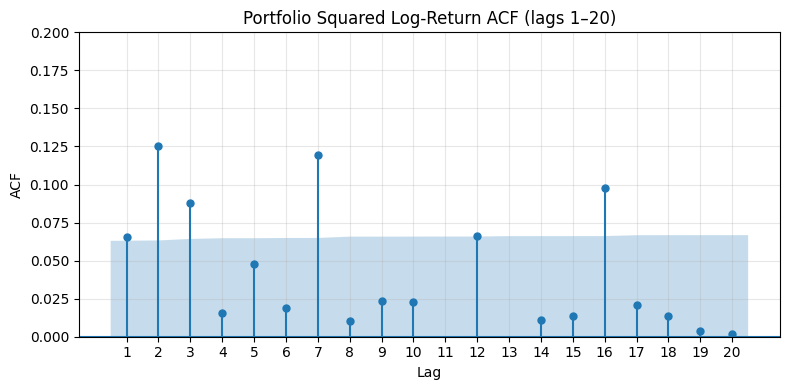

In [29]:
from statsmodels.graphics.tsaplots import plot_acf

# Step 1: Construct the portfolio log return
log_returns = []

for name, df in data_dict.items():
    if 'Close' in df.columns:
        df = df.copy()
        df['log_return'] = np.log(df['Close']).diff()
        log_return_series = df[['log_return']].rename(columns={'log_return': name})
        log_returns.append(log_return_series)

# Combine and align all log returns
log_return_df = pd.concat(log_returns, axis=1).dropna()

# Compute equally weighted portfolio log return
n_assets = log_return_df.shape[1]
log_return_df['portfolio'] = log_return_df.dot(np.repeat(1/n_assets, n_assets))

# Step 2: Square the portfolio log returns
squared_portfolio = log_return_df['portfolio'] ** 2

# Step 3: Plot the ACF of squared returns
nlags = 20
fig, ax = plt.subplots(figsize=(8, 4))
plot_acf(squared_portfolio, lags=nlags, zero=False, ax=ax)

# Customize plot
ax.set_title(f"Portfolio Squared Log-Return ACF (lags 1–{nlags})")
ax.set_xlabel("Lag")
ax.set_ylabel("ACF")
ax.set_xticks(np.arange(1, nlags + 1, 1))
ax.set_ylim(0, 0.2)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Residuals analysis 

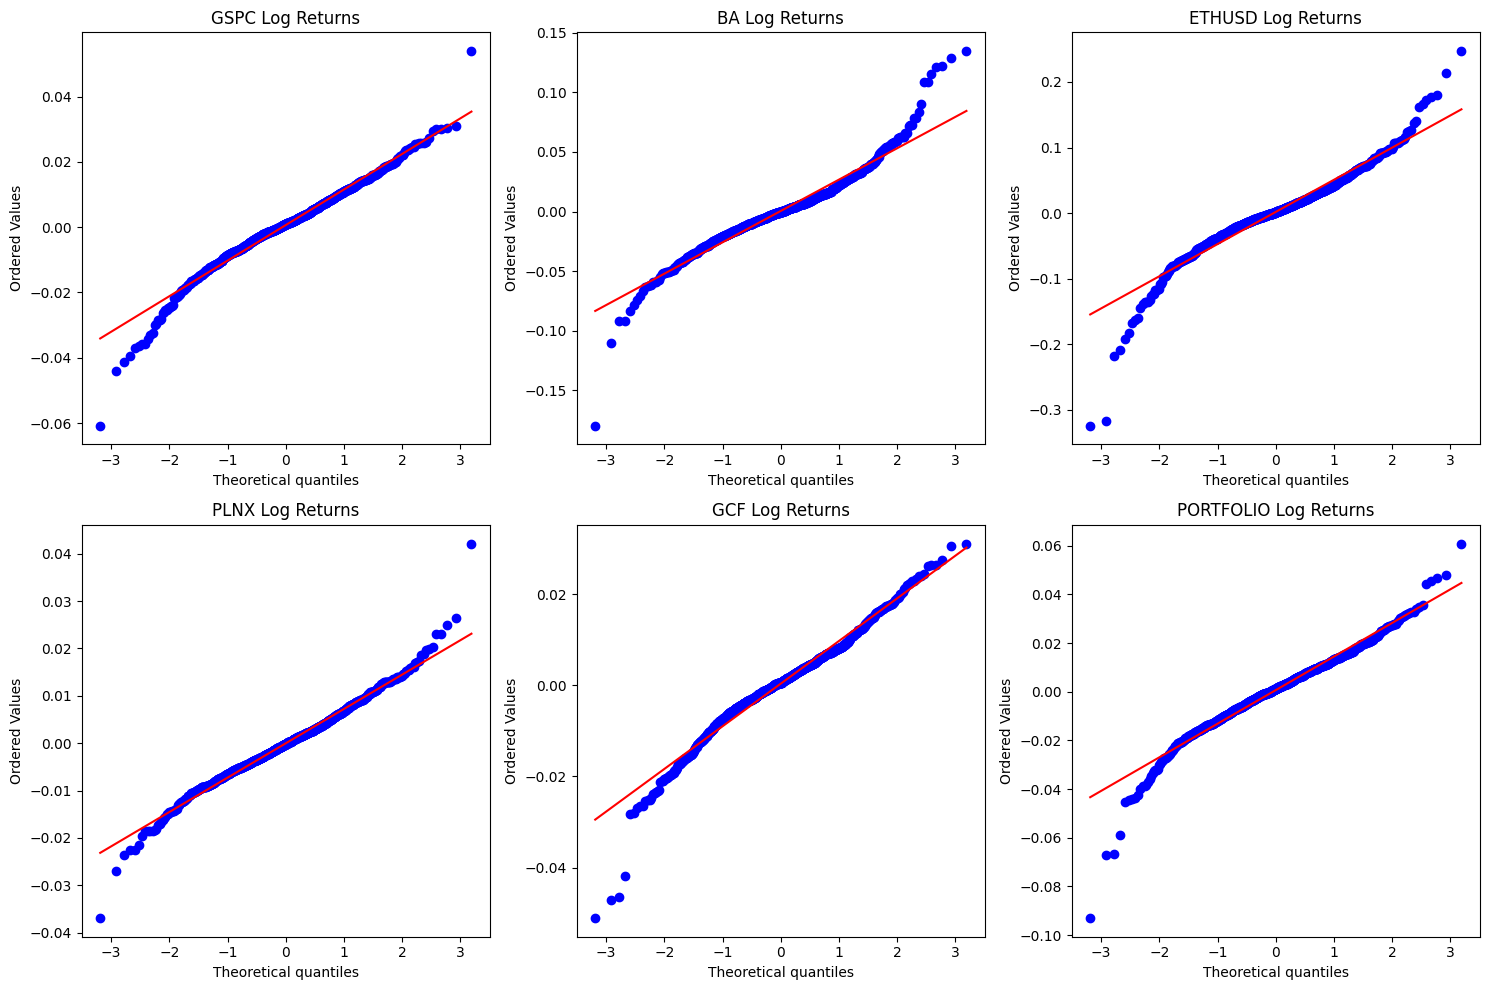

In [38]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Step 1: Prepare asset log returns
assets = [name for name in data_dict if 'Close' in data_dict[name].columns]
log_returns = []

for name in assets:
    df = data_dict[name].copy()
    df['log_return'] = np.log(df['Close']).diff()
    log_return_series = df[['log_return']].rename(columns={'log_return': name})
    log_returns.append(log_return_series)

# Step 2: Create portfolio log returns
log_return_df = pd.concat(log_returns, axis=1).dropna()
n_assets = len(assets)
log_return_df['portfolio'] = log_return_df.dot(np.repeat(1/n_assets, n_assets))

# Add 'portfolio' to the asset list for plotting
assets.append('portfolio')
n_total = len(assets)

# Step 3: Define subplot grid size
ncols = 3
nrows = (n_total + ncols - 1) // ncols

# Step 4: Create figure and subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
axes = axes.flatten()

# Step 5: Plot Q-Q plots for all assets + portfolio
for i, name in enumerate(assets):
    if name == 'portfolio':
        log_returns_series = log_return_df['portfolio']
    else:
        log_returns_series = log_return_df[name]

    stats.probplot(log_returns_series.dropna(), dist="norm", plot=axes[i])
    axes[i].set_title(f"{name.upper()} Log Returns")

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()